In [1]:
import torch
from torch.nn import functional as F
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
from torchmetrics.classification import BinaryAccuracy
import os
from time import sleep
from IPython.display import clear_output
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
from auxilery_functions_and_classes import *
matplotlib.use('Agg')
#%matplotlib inline
%matplotlib tk

## 1. Logistic Regression

Instructions:

1. Fill in the missing code lines (marked with ???) until you reach section 2
2. Run the code and the graphics with three different initial learning rates: 0.5, 3, 0.05
3. The Table shows the conversion after 300 epochs. What are the differences between the learning rates above?
4. The graph shows the conversion after 75 epochs. What are the differences now? Explain your answer.

In [2]:
# Setting fixed seeds
seed = 48 # age of SIPL
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark=False

In [3]:
# Data collection and preperation
device = "cuda" if torch.cuda.is_available() else "cpu" #device to be used for computation

data = pd.read_csv("iris.csv")
data = data[~(data["species"] == "virginica")]
data["label"] = np.where(data["species"] == 'setosa', 1.0, 0.0)
data.drop("species",axis=1,inplace=True)
data.drop("petal_length",axis=1,inplace=True)
data.drop("petal_width",axis=1,inplace=True)

np_data = data.to_numpy()
X = torch.tensor(np_data)
index = torch.randperm(100)
X=X[index]



# TODO: divide the dataset to train(80%) and test(20%) sets and send to device 
len_x=X.shape[0]
eighty=int(len_x*0.8)
X_train = X[0:eighty]
X_test = X[eighty:]


In [4]:
X_train.shape

torch.Size([80, 3])

In [5]:
# Defining hyper-parameters
iters = 300
input_size = 2 # number of features in the data
ouput_size = 1 # binary classification

# TODO: set the learning rate to [0.25,0.1,1.0] 
learning_rate = 0.05

# Define the model, optimizer and loss criterion



# TODO: Complete the model by setting a single linear layer with bias and send to device 
linear_model = torch.nn.Linear(in_features=input_size,out_features=ouput_size).to(device)
# TODO: Complete the optimizer using SGD 
optimizer = torch.optim.SGD(linear_model.parameters(), lr=learning_rate)
# TODO: Complete the criterion using binary cross entropy loss 
criterion = torch.nn.BCELoss()

def logistic_regression_accuracy(output,target,batchsize):
    metric = BinaryAccuracy().to(device)
    preds = torch.where(output>=0.5,1,0)
    acc = metric(preds.reshape(batchsize).to(device),target.to(device))
    return acc

In [6]:
#Set data elements and shapes
train_size = len(X_train)
test_size= len(X_test)
Train_data= X_train[:,:-1].to(torch.float32).to(device)
Train_target = X_train[:,-1].reshape(train_size,ouput_size).float().to(device)
Test_data =X_test[:,:-1].to(device).to(torch.float32)
Test_target = X_test[:,-1].reshape(test_size,ouput_size).float().to(device)
accuracy_train = np.zeros(iters)
loss_train =np.zeros(iters)
accuracy_test = np.zeros(iters)
loss_test =np.zeros(iters)
weights = np.zeros((input_size+1,iters))

print_preformance_grid(Flag=True)

for iter in range(iters):

 





    # TODO: Set model to train mode 
    linear_model.train()
    # TODO: Reset optimizer gradient 
    optimizer.zero_grad()
    # TODO: Use the model on the train inputs to get the outputs. Don't forget an activation! 
    output = F.sigmoid(linear_model(Train_data))
    # TODO: Use the criterion on the outputs and targets to get the train loss 
    loss = criterion(output, Train_target)
    # TODO: Run backward pass 
    loss.backward()
    # TODO: Preform an algorithm step (using the optimizer) 
    optimizer.step()
    loss_train[iter] = loss.item() 

    # TODO: complete the accuracy calculation for the train 
    accuracy = logistic_regression_accuracy(output,Train_target.reshape(train_size),train_size)
    accuracy_train[iter] = accuracy.item()

    with torch.no_grad():

        # TODO: Set the model to evaluation mode 
        linear_model.eval() 

        # TODO: Use the model on the test inputs to get the outputs. Don't forget an activation! 
        output = F.sigmoid(linear_model(Test_data)) 

        # TODO: Complete the accuracy calculation for the test 
        accuracy = logistic_regression_accuracy(output,Test_target.reshape(test_size),test_size)  

        # TODO: Use the criterion on the outputs and targets to get the test loss 
        loss = criterion(output, Test_target)
        accuracy_test[iter] = accuracy.item()
        loss_test[iter] =loss.item()
        
        iter_weigths = linear_model.weight[0].cpu().numpy()
        iter_bias = linear_model.bias[0].cpu().numpy()
        weights[:,iter] =  np.append(iter_weigths,iter_bias)
      
    values = [iter+1, 1, round(loss_train[iter],2),round(accuracy_train[iter],2 ),round(loss_test[iter],2),round(accuracy_test[iter],2)]
    print_preformance_grid(Values=values)

| Epoch | Batch |      Train Loss      | Train Accuracy | Test Loss | Test Accuracy |
-------------------------------------------------------------------------------------
|   1   |   1   |         1.77         |      0.46      |   0.88    |     0.65      |
-------------------------------------------------------------------------------------
|   2   |   1   |         1.3          |      0.46      |   0.77    |     0.65      |
-------------------------------------------------------------------------------------
|   3   |   1   |         0.99         |      0.46      |   0.78    |      0.6      |
-------------------------------------------------------------------------------------
|   4   |   1   |         0.86         |      0.36      |   0.81    |      0.0      |
-------------------------------------------------------------------------------------
|   5   |   1   |         0.82         |      0.01      |   0.83    |     0.05      |
------------------------------------------------------

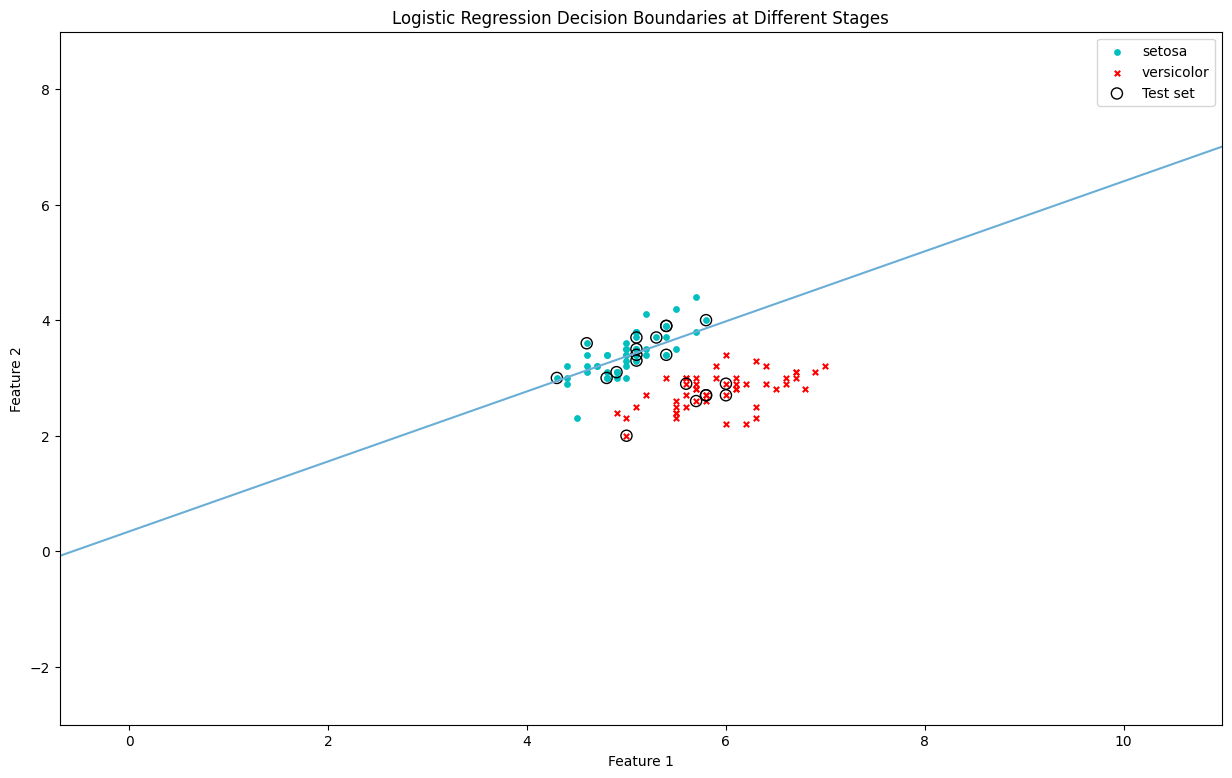

In [7]:
# Plot training process
%matplotlib inline
setosa =  X[X[:,2]>0].cpu().numpy()
versicolor =  X[X[:,2]<1].cpu().numpy()

for ii in range(75):
    plot_perceptron_line(X_test.cpu().numpy(),1,setosa,versicolor,weights[:,ii].reshape(weights.shape[0],1))
    sleep(0.1)
    clear_output(wait=True)

%matplotlib tk

## 2. Fully Connected Neural Network classifier

Instructions:

1. Fill in the missing code lines (marked with ???) until the end of this notebook.
2. Follow the table and conversion graph. What can you say about the conversion?

In [8]:
#Setting fixed seeds
seed = 48 # age of SIPL
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark=False

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#Set data elements and shapes
train = torchvision.datasets.MNIST(root="mnist",train=True, download=True)
test = torchvision.datasets.MNIST(root="mnist",train=False, download=True)
train_size = len(train)
test_size = len(test) 
train_data = train.data.to(torch.float).to(device)
train_labels = train.targets.to(device)
test_data =test.data.to(torch.float).to(device)
test_labels = test.targets.to(device)

# TODO: get the mean and the std of the train set 
train_mean = train_data.mean()
train_std = train_data.std()



# TODO: normalize the train and test sets using the above mean and std  
train_data = (train_data-train_mean)/train_std
test_data = (test_data-train_mean)/train_std
 

In [10]:
# Display a few samples
display_Mnist1(train)

In [11]:
# Creating a Fully Connected Neural Network Architeture Class 
class Multi_Layerd_Perceptron(nn.Module):
    def __init__(self,input_size,hidden_layer_size,output_size):
      super(Multi_Layerd_Perceptron,self).__init__()


      # TODO: define the network fully connected layers 
      self.linear_layer1 = torch.nn.Linear(in_features=input_size,out_features=hidden_layer_size) 
      self.linear_layer2 =  torch.nn.Linear(in_features=hidden_layer_size,out_features=output_size)  

      # TODO: define the flatten layer 
      self.flatten = torch.nn.Flatten()
      
    def forward(self,x):
       



      # TODO: complete the first layer, operating on flattaned inputs 
      z1 = self.linear_layer1(self.flatten(x))
      # TODO: complete the activation layer 
      z2 = F.sigmoid(z1) 
      # TODO: complete the output layer 
      out = self.linear_layer2(z2)
       
      return out

In [12]:
# Defining a Params object for this part
hparams = Hyper_Params()
hparams.lr =  0.3 
hparams.epochs = 30 
hparams.batch_size = 64
hparams.space = 1000 # for visualisation
hparams.iter_break = int(np.ceil(train_size/hparams.batch_size)) # how many iterations the model trains on befor validation rounds
hparams.lines = int(np.ceil(train_size/hparams.batch_size)) # for visualisation

In [13]:
train_data[0].shape[0]*train_data[0].shape[1]

784

In [14]:
# Define the model, optimizer, loss criterion and all the parameters relevant to the question
acc_function = multi_class_accuracy


input_size = train_data[0].shape[0]*train_data[0].shape[1]
# TODO: Set the multi layer perceptron model with a hidden layer of size 200 and send to device 
model = Multi_Layerd_Perceptron(input_size,200,10).to(device)
# TODO: Sefine the optimizer using sgd 
optimizer = torch.optim.SGD(model.parameters(), lr=hparams.lr) 
# TODO: Sefine the criterion using cross entropy loss 
criterion = torch.nn.CrossEntropyLoss() 

print(f"Train a Multilayer Perceptron with one hidden layer of size 200")
print(f"Learning rate: {hparams.lr}")
print(f"Batch size: {hparams.batch_size}")

Train a Multilayer Perceptron with one hidden layer of size 200
Learning rate: 0.3
Batch size: 64


In [15]:
# Evaluation function
def evaluate_mnist(Model,test_data,test_labels,criterion,acc_function):
    out = Model(test_data)
    loss = criterion(out,test_labels.squeeze())
    accuracy = acc_function(out,test_labels.squeeze())
    return loss.item(), accuracy 

In [16]:

# Training
hparams.fig, (hparams.ax1, hparams.ax2) = plt.subplots(2, 1, figsize=(15, 9))
print_preformance_grid(Flag=True)

for epoch in range(hparams.epochs):

      # TODO: reset the optimizer gradient 
      model.train()
      hparams.epoch_accuracy_train = np.zeros(int(np.ceil(train_size/hparams.batch_size)))
      hparams.epoch_loss_train = np.zeros(int(np.ceil(train_size/hparams.batch_size)))
      index = torch.randperm(60000)
      train_data_perm = train_data[index]
      train_labels_perm = train_labels[index]
      for i,batch in enumerate(range(0,train_size,hparams.batch_size)):
            optimizer.zero_grad()
            data = train_data_perm[batch:batch+hparams.batch_size]
            target = train_labels_perm[batch:batch+hparams.batch_size]
            output = model(data.to(device))
           
            loss = criterion(output,target.squeeze().to(device))
            accuracy = acc_function(output,target.squeeze().to(device))



            # TODO: Run backward pass
            loss.backward()
            # TODO: Preform an algorithm step (using the optimizer) 
            optimizer.step()
            
            hparams.epoch_accuracy_train[i] = accuracy
            hparams.epoch_loss_train[i] = loss.item()
            if (i) % hparams.iter_break==0 and epoch==0 or (i+1) == int(np.ceil(train_size/hparams.batch_size)):
                  model.eval()
                  test_loss,test_accuracy = evaluate_mnist(model,test_data,test_labels,criterion,acc_function)
                  print_performance(epoch,i,hparams,test_loss,test_accuracy)
                  model.train()
                      
plt.show()

| Epoch | Batch |      Train Loss      | Train Accuracy | Test Loss | Test Accuracy |
-------------------------------------------------------------------------------------
|   0   |   0   |         2.41         |      0.09      |    2.4    |     0.11      |
-------------------------------------------------------------------------------------
|   1   |  938  |         0.34         |      0.9       |    0.2    |     0.94      |
-------------------------------------------------------------------------------------
|   2   |  938  |         0.16         |      0.95      |   0.13    |     0.96      |
-------------------------------------------------------------------------------------
|   3   |  938  |         0.11         |      0.97      |   0.11    |     0.97      |
-------------------------------------------------------------------------------------
|   4   |  938  |         0.08         |      0.98      |   0.09    |     0.97      |
------------------------------------------------------

KeyboardInterrupt: 